Index(['height', 'outflow', 'pump1_rpm', 'pump1_power', 'pump4_rpm',
       'pump4_power'],
      dtype='object')


<bound method Figure.show of <Figure size 640x480 with 2 Axes>>

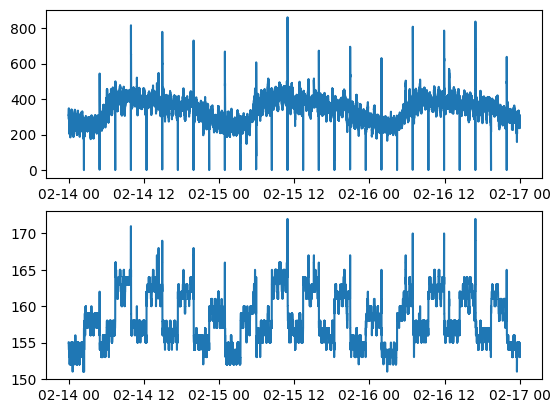

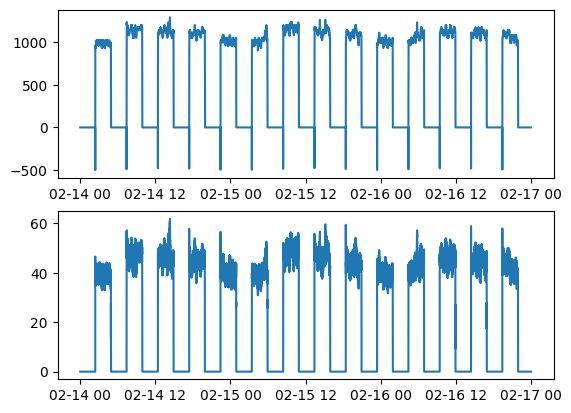

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_parquet('Data/pump_station_data.parquet')
data = data[:]["2023-02-14":"2023-02-16"]
print(data.columns)
fig, ax = plt.subplots(2)
ax[0].plot(data['outflow'])
ax[1].plot(data['height'])
fig.show
fig, ax = plt.subplots(2)
ax[0].plot(data['pump1_rpm'])
ax[1].plot(data['pump1_power'])
fig.show
# Building a static model of the 


In [8]:
import sklearn.model_selection as modsel

data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)


In [9]:
# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_train = data_train.drop(labels=['height','outflow', 'pump1_power', 'pump4_power'], axis=1)
x_train = x_train.to_numpy()
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test.drop(labels=['height','outflow', 'pump1_power', 'pump4_power'], axis=1)
x_test = x_test.to_numpy()
y_test = data_test['outflow'].values.reshape(-1,1)

In [11]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [4]:

# The model is fitted 
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_best = []
yhat_best = []
for a in range(2,7):
    for i in range(1,5):
                    for j in range(1,20):
                            model = FROLS(
                                order_selection=True,
                                n_terms = a,
                                extended_least_squares=False,
                                ylag=1,
                                xlag=[[i, j],[i,j]],
                                info_criteria="aic",
                                estimator="least_squares",
                                basis_function=basis_function,
                            )

                            model.fit(X=x_train, y=y_train)
                            yhat = model.predict(X=x_test,y=y_test)
                            rrse = root_relative_squared_error(y_test, yhat)
                            if rrse < rrse_low:
                                rrse_low = rrse
                                i_j_a_best = [i,j,a]
                                yhat_best = yhat


/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6
  self.info_values = self.information_criterion(reg_matrix, y)
/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/parameter_estimation/estimators.py:114:

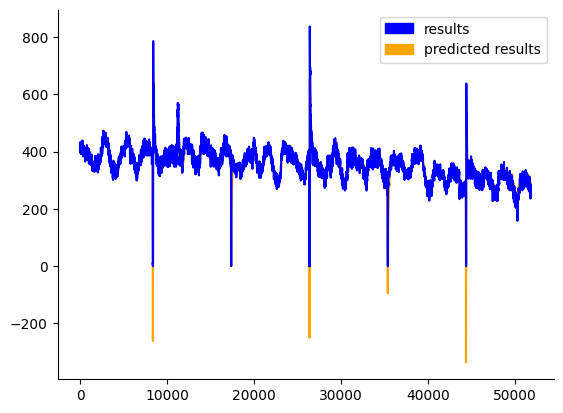

In [6]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat_best, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()

In [7]:
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

  Regressors   Parameters             ERR
0     y(k-1)   9.8973E-01  9.99888385E-01
1          1  -3.9370E+00  7.04000905E-08
2   x2(k-19)  -3.3187E-02  2.53472876E-08
3    x2(k-4)   4.1304E-02  9.49459351E-06
4    x1(k-4)   2.6489E-02  3.97108259E-06
5   x1(k-19)  -1.9554E-02  2.94604879E-06


NameError: name 'mpatches' is not defined

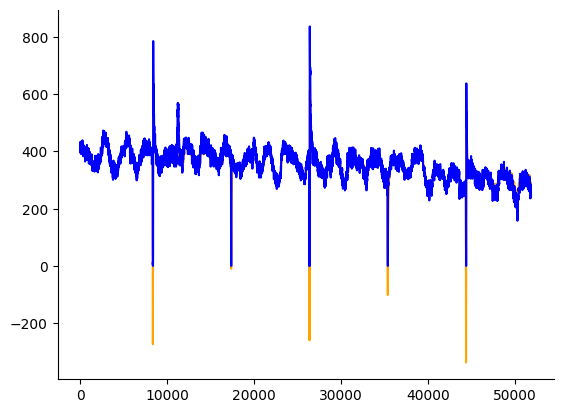

In [12]:
from sklearn.linear_model import BayesianRidge
from sysidentpy.general_estimators import NARX
from sysidentpy.basis_function._basis_function import Polynomial
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_best = []
yhat_best = []
for a in range(2,5):
        for i in range(1,5):
                        for j in range(1,20):
                                
                                BayesianRidge_narx = NARX(
                                base_estimator=BayesianRidge(),
                                xlag=[[i, j],[i,j]],
                                ylag=a,
                                basis_function=basis_function,
                                model_type="NARMAX",
                                )

                                BayesianRidge_narx.fit(X=x_train, y=y_train)
                                yhat = BayesianRidge_narx.predict(X=x_test,y=y_test)
                                rrse = root_relative_squared_error(y_test, yhat)
                                if rrse < rrse_low:
                                        rrse_low = rrse
                                        i_j_a_best = [i,j,a]
                                        yhat_best = yhat

                




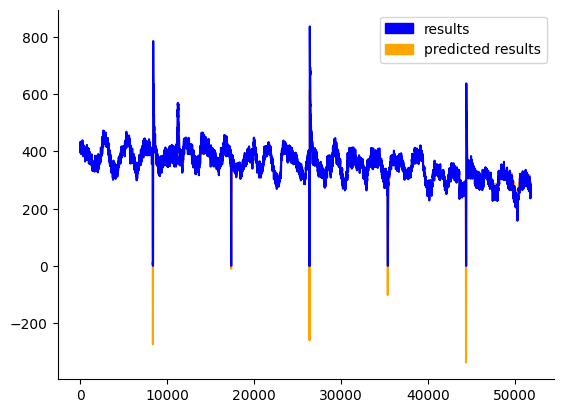

In [13]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat_best, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()


In [14]:
print(i_j_a_best)
print(rrse_low)

[3, 7, 3]
0.36612898381430314
